In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
from transformers import AutoModel, AutoTokenizer

from group_sae.utils import palette

/workspace/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## FLOPs

In [30]:
from torch.utils.flop_counter import FlopCounterMode

device = "cuda"

# Load GPT-2 model and tokenizer
model_name = "EleutherAI/pythia-1b-deduped"
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.to(device)
model.eval()
print("Model running on", device)

Model running on cuda


In [31]:
N_TOKENS = 1e9
ctx_len = 1024
d_model = 2048
n_layers = 16
n_batches = N_TOKENS // ctx_len

In [ ]:
# Prepare a sample input with 1024 tokens
input_text = "Sample input."
input_text += " null" * (ctx_len - len(tokenizer(input_text)["input_ids"]))
inputs = tokenizer(input_text, return_tensors="pt")["input_ids"]
print(f"Input shape: {inputs.shape}")

cache = {}


def forward_hook(module, input, output):
    cache["output"] = output[0].flatten(0, 1)


model.layers[0].register_forward_hook(forward_hook)

# Enable flop counting
with FlopCounterMode(model) as flop_counter:
    with torch.no_grad():
        outputs = model(inputs.to(device))

# Retrieve FLOPs count
flops = flop_counter.get_total_flops() * n_batches
print(f"PFLOPs required for caching 1B tokens: {flops / 1e15:.2f} PFLOPs")

Input shape: torch.Size([1, 1024])
Module                                                FLOP    % Total
-----------------------------------------------  ---------  ---------
GPTNeoXModel                                     1786.706B    100.00%
 - aten.bmm                                         0.000B      0.00%
 - aten.addmm                                    1649.267B     92.31%
 - aten._scaled_dot_product_efficient_attention   137.439B      7.69%
 GPTNeoXModel.rotary_emb                            0.000B      0.00%
  - aten.bmm                                        0.000B      0.00%
PFLOPs required for caching 1B tokens: 1744.83 PFLOPs


/tmp/ipykernel_4316/3655135618.py:14: UserWarning: mods argument is not needed anymore, you can stop passing it
  with FlopCounterMode(model) as flop_counter:


In [33]:
import torch.nn as nn


# We use a standard SAE as FLOP count doesn't change between architectures.
class SAE(nn.Module):
    def __init__(self, c, sparsity=1):
        super(SAE, self).__init__()
        self.sparsity = sparsity
        self.encoder = nn.Linear(d_model, d_model * c)
        self.decoder = nn.Linear(d_model * c, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.encoder(x)
        h = self.relu(h)
        return self.decoder(h), h

    def get_loss(self, x, y):
        x_hat, h = self(x)
        l2_loss = (x_hat - y).pow(2).sum()
        fvu = l2_loss / x.pow(2).sum()
        l1_loss = h.abs().sum(-1).mean()
        print(f"l2_loss: {l2_loss.item()}, l1_loss: {l1_loss.item()}")
        return fvu + l1_loss * self.sparsity

In [34]:
def training_step(sae, inputs, optimizer):
    optimizer.zero_grad()
    loss = sae.get_loss(inputs, inputs)
    loss.backward()
    optimizer.step()


c = 16

sae = SAE(c=c, sparsity=1)
sae.to(device)
optimizer = torch.optim.Adam(sae.parameters(), lr=1e-3)

In [35]:
# Enable flop counting
with FlopCounterMode(sae) as flop_counter:
    training_step(sae, cache["output"], optimizer)

# Retrieve FLOPs count
flops = flop_counter.get_total_flops() * n_batches  # * n_layers
print(f"PFLOPs for the forward pass: {flops / 1e15:.2f} PFLOPs")

l2_loss: 909004.0, l1_loss: 4792.55224609375
Module               FLOP    % Total
---------------  --------  ---------
Global           687.195B    100.00%
 - aten.addmm    274.878B     40.00%
 - aten.mm       412.317B     60.00%
 SAE             412.317B     60.00%
  - aten.addmm   274.878B     40.00%
  - aten.mm      137.439B     20.00%
  SAE.decoder    412.317B     60.00%
   - aten.addmm  137.439B     20.00%
   - aten.mm     274.878B     40.00%
  SAE.encoder    274.878B     40.00%
   - aten.addmm  137.439B     20.00%
   - aten.mm     137.439B     20.00%
PFLOPs for the forward pass: 671.09 PFLOPs


/tmp/ipykernel_4316/4198970078.py:2: UserWarning: mods argument is not needed anymore, you can stop passing it
  with FlopCounterMode(sae) as flop_counter:


| Model       |  L |    D |       A |      T |
|-------------|----|------|---------|--------|
| Pythia-160m | 12 |  768 |  207.62 |  94.37 |
| Pythia-410m | 24 | 1024 |  704.64 | 167.77 |
| Pythia-1b   | 16 | 2048 | 1744.83 | 671.09 |

All results are in PFLOPs (1e15)

## AMD

### Fix evals

In [213]:
from group_sae import MODEL_MAP
from group_sae.utils import load_cluster_map, load_amds
import numpy as np

columns = ["ce_loss_score", "explained_variance", "mse", "l2_ratio", "layer", "G"]


def load_cluster_eval(size):

    nl = MODEL_MAP[f"pythia-{size}-deduped"]["n_layers"]

    labels = []
    clusters = []
    for c in load_cluster_map(size).values():
        lab_ = list(dict.fromkeys(c))
        label_map = {v: i for i, v in enumerate(lab_)}
        clusters += [label_map[i] for i in c]
        labels += c

    cluster_eval = pd.read_csv(f"../eval/pythia-{size}_cluster.csv", index_col=0)[columns]
    cluster_eval["label"] = labels[: len(cluster_eval)]
    cluster_eval.drop(columns="G", inplace=True)

    base_eval = pd.read_csv(f"../eval/pythia-{size}_baseline.csv", index_col=0)[columns]
    base_eval["label"] = base_eval["layer"].apply(lambda x: f"layers.{x}")
    base_eval.drop(columns="G", inplace=True)

    unique_eval = pd.concat([base_eval, cluster_eval]).drop_duplicates()

    empty_evals = pd.DataFrame(
        {"layer": list(range(nl-1)) * (nl-2), "cluster": clusters, "label": labels, "G": np.arange(1, nl-1).repeat(nl - 1)}
    )
    eval = pd.merge(empty_evals, unique_eval, how="left").drop(columns="label")
    eval = eval.groupby(["G", "cluster", "layer"]).mean().reset_index()

    # Fill AMDs
    amd = load_amds(size)
    clusters = []
    for c in load_cluster_map(size).values():
        labels = list(dict.fromkeys(c))
        label_map = {v: i for i, v in enumerate(labels)}
        clusters += [label_map[i] for i in c]

    return pd.merge(eval, amd, on="G")

In [214]:
p160 = load_cluster_eval("160m")
# p410 = load_cluster_eval("410m")
p1 = load_cluster_eval("1b")

In [219]:
p160_plot = p160.groupby("G").mean()
# p410_plot = p410.groupby("G").mean()
p1_plot = p1.groupby("G").mean()

In [220]:
base_160m = pd.read_csv(f"../eval/pythia-160m_baseline.csv", index_col=0)[columns]
base_410m = pd.read_csv(f"../eval/pythia-410m_baseline.csv", index_col=0)[columns]
base_1b = pd.read_csv(f"../eval/pythia-1b_baseline.csv", index_col=0)[columns]

Text(0, 0.5, 'CE Loss Score')

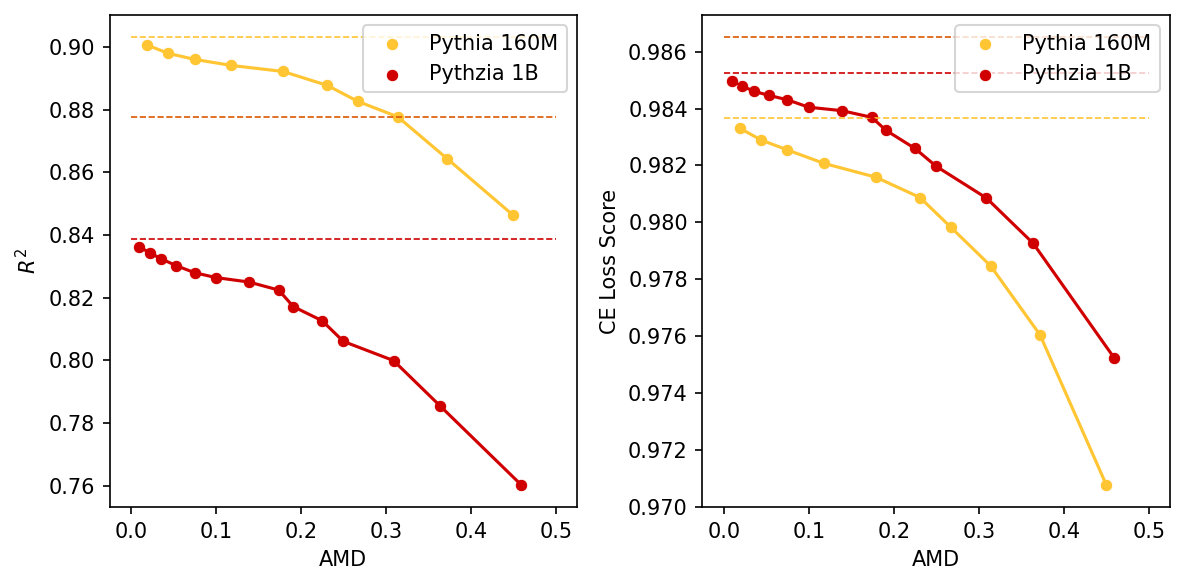

In [236]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=150, layout="tight")

def plot_vs_amd(metric, ax):
    sns.lineplot(p160_plot, x="AMD", y=metric, color=palette[0], ax=ax)
    sns.scatterplot(p160_plot, x="AMD", y=metric, label="Pythia 160M", color=palette[0], ax=ax)
    ax.hlines(base_160m.mean()[metric], 0, 0.5, colors=palette[0], linestyles="--", linewidth=0.8)

    # sns.lineplot(p410_plot, x="AMD", y=metric, color=palette[2], ax=ax)
    # sns.scatterplot(p410_plot, x="AMD", y=metric, label="Pythia 410M", color=palette[2], ax=ax)
    ax.hlines(base_410m.mean()[metric], 0, 0.5, colors=palette[2], linestyles="--", linewidth=0.8)

    sns.lineplot(p1_plot, x="AMD", y=metric, color=palette[3], ax=ax)
    sns.scatterplot(p1_plot, x="AMD", y=metric, label="Pythzia 1B", color=palette[3], ax=ax)
    ax.hlines(base_1b.mean()[metric], 0, 0.5, colors=palette[3], linestyles="--", linewidth=0.8)

    ax.set_xlabel("AMD")

plot_vs_amd("explained_variance", ax[0])
ax[0].set_ylabel(r"$R^2$")

plot_vs_amd("ce_loss_score", ax[1])
ax[1].set_ylabel("CE Loss Score")

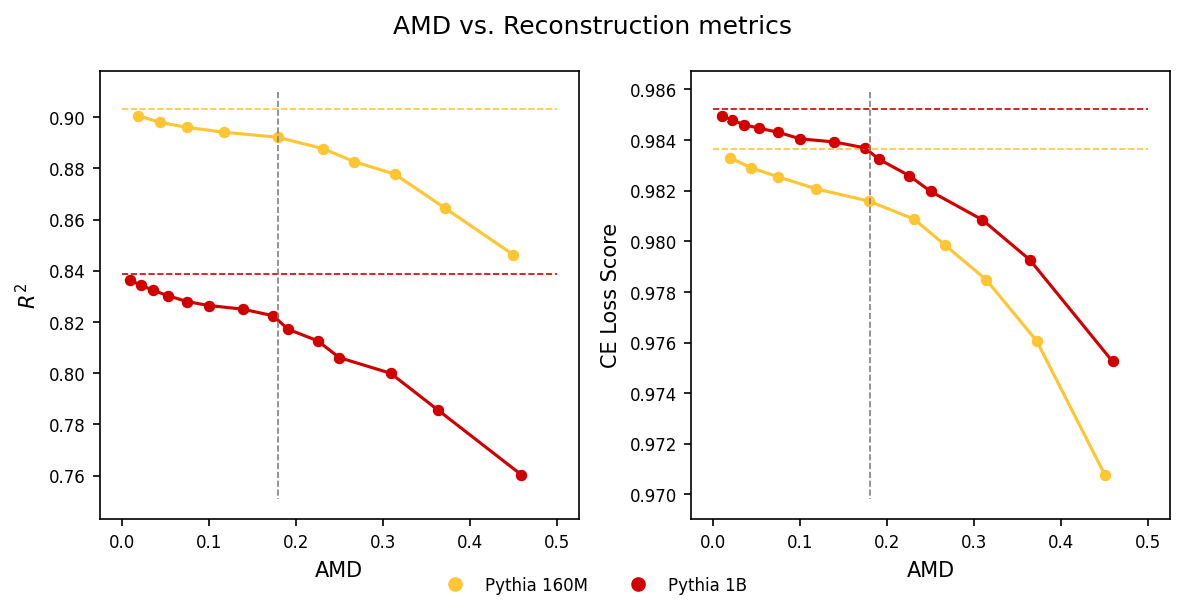

In [250]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=150, layout="tight")

def plot_vs_amd(metric, ax):
    sns.lineplot(p160_plot, x="AMD", y=metric, color=palette[0], ax=ax)
    sns.scatterplot(p160_plot, x="AMD", y=metric, color=palette[0], ax=ax, legend=False)
    ax.hlines(base_160m.mean()[metric], 0, 0.5, colors=palette[0], linestyles="--", linewidth=0.8)

    sns.lineplot(p1_plot, x="AMD", y=metric, color=palette[3], ax=ax)
    sns.scatterplot(p1_plot, x="AMD", y=metric, color=palette[3], ax=ax, legend=False)
    ax.hlines(base_1b.mean()[metric], 0, 0.5, colors=palette[3], linestyles="--", linewidth=0.8)

    all_ = pd.concat([p160_plot, p1_plot])
    max_ = all_[metric].max()
    min_ = all_[metric].min()
    delta = (max_ - min_) / 15
    ax.vlines(0.18, max_+delta, min_-delta, colors="grey", linestyles="--", linewidth=0.8)

    ax.set_xlabel("AMD")
    ax.tick_params(labelsize=8)  # Reduce tick size

plot_vs_amd("explained_variance", ax[0])
ax[0].set_ylabel(r"$R^2$")

plot_vs_amd("ce_loss_score", ax[1])
ax[1].set_ylabel("CE Loss Score")

# Create a single unique legend without a frame
handles = [
    plt.Line2D([0], [0], marker='o', color=palette[0], linestyle='', label="Pythia 160M"),
    plt.Line2D([0], [0], marker='o', color=palette[3], linestyle='', label="Pythia 1B")
]
fig.legend(handles=handles, loc="lower center", ncol=2, fontsize=8, frameon=False)
fig.suptitle("AMD vs. Reconstruction metrics")

plt.show()